In [1]:
import torch

import torchvision
import torchvision.transforms as transforms

import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

print(torch.__version__)

2.0.1


In [4]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

print(np.__version__)

def imgshow(title, image = None, size =6):
    w,h = image.shape[0], image.shape[1]
    aspect_ratio = w/h
    plt.figure(figsize=(size*aspect_ratio, size))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.show()

1.25.2


In [5]:
# Transformers are needed to cast the image data into the required format for input into our model
# Convert to tensors and normalize
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,))])

In [6]:
# Fetch MNIST dataset using torchvision for training and test
trainset = torchvision.datasets.MNIST('mnist',
                                      train = True, 
                                      download = True,
                                      transform = transform)
testset = torchvision.datasets.MNIST('mnist',
                                     train=False,
                                     download=True,
                                     transform = transform)

In [7]:
print(trainset.data.shape)
print(testset.data.shape)

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


In [22]:
!pip install numpy --upgrade

     -------------------------------------- 15.1/15.1 MB 570.2 kB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.1
    Uninstalling numpy-1.23.1:
      Successfully uninstalled numpy-1.23.1


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.3.0 requires daal==2021.2.3, which is not installed.
scipy 1.7.1 requires numpy<1.23.0,>=1.16.5, but you have numpy 1.25.1 which is incompatible.


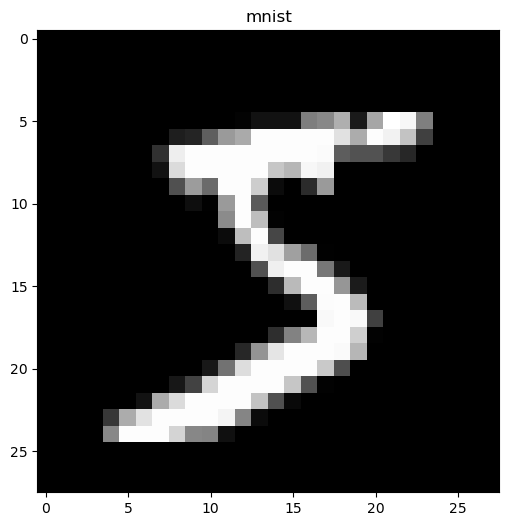

In [8]:
# to plot the image in opencv, we need to convert the image to numpy array
image = trainset.data[0].numpy()
imgshow("mnist",image)

In [9]:
# A dataloader is a function that we will use to grab our data in specified batch sizes (we'l use 128) during training
# Prepare train and test loader

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size = 128,
                                          shuffle = True,
                                          num_workers = 0)
testloader = torch.utils.data.DataLoader(testset,
                                         batch_size = 128,
                                         shuffle = False,
                                         num_workers = 0)

In [11]:
# Using Iter and Next() for load batches
dataiter = iter(trainloader)

labels = next(dataiter)

#print(images.shape)
#print(labels.shape)

Building a Convolution Model

In [12]:
import torch.nn as nn
import torch.nn.functional as F

#Create model using a Python class
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1,32,3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(64 * 12 * 12, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64*12*12)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
# create an instance of the model and move memory and operations to CUDA device
net = Net()
net.to(device)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [13]:
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [14]:
# defining a loss function and an optimizer

import torch.optim as optim
# using cross entropy as the loss function
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(net.parameters(), lr=0.001, momentum = 0.9)

In [20]:
epochs = 10
#create some empty arrays to store
epoch_log = []
loss_log = []
accuracy_log = []

# Iterate for a specified number of epochs
for epoch in range(epochs):
    print(f'Starting Epoch: {epoch+1}...')

    running_loss = 0.0

    #We iterate through our trainloader iterator
    # each cycle is a mini batch
    for i, data in enumerate(trainloader, 0):
        inputs, data = data
        # Move our data to GPU
        inputs = inputs.to(device)
        labels = np.asarray(labels)
        labels = torch.from_numpy(labels.astype('long'))
        labels = labels.to(device)
        # clear the gradients before training starts
        optimizer.zero_grad()
        #Forward -> backprop + optimize
        outputs = net(inputs) #Forward Propagation 
        loss = criterion(outputs, labels) # Get Loss (quantify the difference between the results and predictions)
        loss.backward() # Back propagate to obtain the new gradients for all nodes
        optimizer.step() # Update the gradients/weights

        # Print training stats - Epochs/Iterations/Loss/Accuracy
        running_loss += loss.item()
        if i % 50 == 49: # show loss after 50 iterations
            correct = 0
            total = 0
            # torch.no_grad() disables backpropagation and gradient calcualtion which we dont need during test
            with torch.no_grad():
                for data in testloader:
                    images, labels = data
                    # Move our data to GPU
                    images = images.to(device)
                    labels = np.asarray(labels)
                    labels = torch.from_numpy(labels.astype('long'))
                    labels = labels.to(device)
                    outputs = net(images)
                    # Get predictions from the maximum value of the predicted output tensor
                     # we set dim = 1 as it specifies the number of dimensions to reduce
                    _, predicted = torch.max(outputs.data, dim =1)
                    total += labels.size(0)
                    # Keep a running total of the number of predictions predicted correctly
                    correct += (predicted == labels).sum().item()
                accuracy = 100 * correct / total
                epoch_num = epoch + 1
                actual_loss = running_loss / 50
                print(f'Epoch: {epoch_num}, Mini-Batches Completed: {(i+1)}, Loss: {actual_loss:.3f}, Test Accuracy = {accuracy:.3f}%')
                running_loss = 0.0

    # Store training stats after each epoch
    epoch_log.append(epoch_num)
    loss_log.append(actual_loss)
    accuracy_log.append(accuracy)

print("finished training")




Starting Epoch: 1...


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (2, 128) + inhomogeneous part.

In [ ]:
# Saving our model
torch.save(net.state_dict(), ".")